In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
import os
import numpy as np
import pyspark.sql.functions as f
import subprocess
from pyspark.sql.functions import min, max, col
from pyspark.sql.functions import *

In [2]:
sc = SparkContext()
sqlcontext = SQLContext(sc)

In [3]:
t1_df = sqlcontext.read.csv("0611_t1_/part-00000")
t2_df = sqlcontext.read.csv("0611_t2_/part-00000")
t3_df = sqlcontext.read.csv("0611_t3_/part-00000")

In [15]:
t1_df.show()
t2_df.show()
t3_df.show()

+--------+--------------------+--------------------+
|     _c0|                 _c1|                 _c2|
+--------+--------------------+--------------------+
|11110515|   3551885.220191556| 0.10462627666625963|
|11110530|   6542603.536111111|  0.2535531622076898|
|11110540|   4868209.412191582| 0.17017442984200543|
|11110550|  1874859.7026955972| 0.02111651047907305|
|11110560|   2101632.571773221|0.032408973877332256|
|11110570|   3252494.960227273| 0.08971773153829407|
|11110580|   3123166.901217862| 0.08327766497004963|
|11110600|    4128184.03090792| 0.13332385963967625|
|11110615|1.2166911400230903E7|  0.5336232206518247|
|11110630|   6744465.979880775|  0.2636051771026984|
|11110640|  3549663.6728919074| 0.10451565169744911|
|11110650|  3728810.8103448274| 0.11343652702445986|
|11110670|  6019458.6902133925| 0.22750245319511483|
|11110680|  3017735.4423555005| 0.07802756210249381|
|11110690|  2759760.3188720173|  0.0651813400149589|
|11110700|  3048575.1900537633| 0.079563269277

In [27]:
t1 = t1_df.selectExpr("_c0 as Dong1", "_c2 as t1", "_c1 as value1")
t2 = t2_df.selectExpr("_c0 as Dong2", "_c2 as t2", "_c1 as value2")
t3 = t3_df.selectExpr("_c0 as Dong3", "_c1 as t3", "_c2 as value3")
t1 = t1.withColumn('Dong1_', regexp_replace('Dong1', '(^11305606)', '11305608'))
t2 = t2.withColumn('Dong2_', regexp_replace('Dong2', '(^11305606)', '11305608'))
t3 = t3.withColumn('Dong3_', regexp_replace('Dong3', '(^11305606)', '11305608'))

In [17]:
t3.show(424)

+--------+--------------------+------+--------+
|   Dong3|                  t3|value3|  Dong3_|
+--------+--------------------+------+--------+
|11110515|                 0.0|     0|11110515|
|11110530| 0.06666666666666667|     7|11110530|
|11110540|                 0.0|     0|11110540|
|11110550| 0.01904761904761905|     2|11110550|
|11110560| 0.01904761904761905|     2|11110560|
|11110570|                 0.0|     0|11110570|
|11110580|0.009523809523809525|     1|11110580|
|11110600|                 0.0|     0|11110600|
|11110615|                 1.0|   105|11110615|
|11110630| 0.26666666666666666|    28|11110630|
|11110640|                 0.0|     0|11110640|
|11110650| 0.06666666666666667|     7|11110650|
|11110670| 0.29523809523809524|    31|11110670|
|11110680|  0.0380952380952381|     4|11110680|
|11110690|                 0.0|     0|11110690|
|11110700| 0.02857142857142857|     3|11110700|
|11110710|  0.3047619047619048|    32|11110710|
|11140520| 0.22857142857142856|    24|11

In [18]:
joined = t2.join(t3, t2.Dong2_ == t3.Dong3_, how='right')
joined2 = joined.join(t1, t1.Dong1_ == joined.Dong2_, how='right')


In [11]:
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
abc = joined2.toPandas()
abc=abc.astype(float)
bbb=abc.groupby(  pd.cut(abc["t2"], np.arange(0, 1, 0.1))  ).count()#.agg(count('Dong2')) #.sort('Dong2').toPandas()
bbb

NameError: name 'pd' is not defined

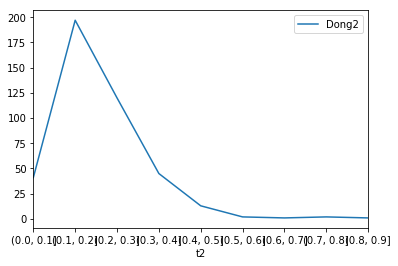

In [67]:
bbb.plot(y='Dong2',  use_index=True)
#abc.plot(x='Dong1', y='t2')

In [19]:
joined2.show(424)

+--------+--------------------+--------------------+--------+--------+--------------------+------+--------+--------+--------------------+--------------------+--------+
|   Dong2|                  t2|              value2|  Dong2_|   Dong3|                  t3|value3|  Dong3_|   Dong1|                  t1|              value1|  Dong1_|
+--------+--------------------+--------------------+--------+--------+--------------------+------+--------+--------+--------------------+--------------------+--------+
|11410660| 0.11322724009040452|2.5575276802809995E8|11410660|11410660|  0.0380952380952381|     4|11410660|11410660|0.028315901067998472|  2019436.3465935742|11410660|
|11530770|  0.1488473894459436|3.3617804458669966E8|11530770|11530770| 0.18095238095238095|    19|11530770|11530770| 0.05292022539982611|   2513535.200286123|11530770|
|11590520|  0.1819076531847171| 4.108234602404001E8|11590520|11590520|  0.0761904761904762|     8|11590520|11590520| 0.12622678715131033|  3985662.1175327827|11

In [23]:
joined2.select(["Dong2_", "t1", 'value1' ,"t2", "value2", "t3", "value3"]).write.csv("0611_score_3")

In [24]:
sc.textFile("hdfs://master:9000/user/hadoop/0611_score_3/part*").coalesce(1).saveAsTextFile("hdfs://master:9000/user/hadoop/0611_score_3_")